# Compare Result

this notebook created for comparing result between predicted result from ML model and truth set 

In [1]:
!pip install venn

# BAT

## Result V2

In [63]:
import csv
from venn import venn
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

from functools import reduce

In [2]:
columns = ["ID_Query","ID_Target","sequence_identity","alignment_length","number_of_mismatches","number_of_gap_openings", "start-position_in_query", "end-position_in_query", "start-position_in_target","end-position_in_target","E-value","bit_score"]

In [3]:
method_dict = {
    'Ensemble': "Ensemble",
    'FastAI': 'FastAI', 
    'RF' : "RF",
    "XGBoost": "XG",
    "SVM": "SVM",
    "AmPep30": "ShortCNN",
    "CNN_RMSpop": "CNN_RMSpop",
    "CNN_Adam": "CNN_Adam",
    "ProtCNN" : "ProtCNN",
    "DNN" : "DNN"
}


_df_to_report_200 =  pd.DataFrame( columns=["AMP","NonAMP","Match(MMseq)","Accuracy %","_100_Match(MMseq)","_100_Accuracy %","_80_Match(MMseq)","_80_Accuracy %"],
    index = ['Ensemble','FastAI', 'RF',"XGBoost","SVM","AmPep30","CNN_RMSpop","CNN_Adam","ProtCNN","DNN"])

_df_to_report_30 =  pd.DataFrame( columns=["AMP","NonAMP","Match(MMseq)","Accuracy %"],
    index = ['Ensemble','FastAI', 'RF',"XGBoost","SVM","AmPep30","CNN_RMSpop","CNN_Adam","ProtCNN","DNN"])

_df_to_report =  pd.DataFrame( columns=["AMP","NonAMP","Match(MMseq)","Accuracy %","_100_Match(MMseq)","_100_Accuracy %","_80_Match(MMseq)","_80_Accuracy %"],
    index = ['Ensemble','FastAI', 'RF',"XGBoost","SVM","AmPep30","CNN_RMSpop","CNN_Adam","ProtCNN","DNN"])

In [4]:
def plot_ven_AMP_NonAMP(sample_test,sample_groundtruth,prediced_set,truth_set):
    Samples = {
        sample_test: set(prediced_set["ID"]),
        sample_groundtruth: set(truth_set['ID_Query']),
        }
    venn(Samples)
    # venn(Samples, fmt="{percentage:.2f}%")    
    
def accuracy_cal( predict , total_AMPs, per):
    accuracy = (predict/total_AMPs )*100
    print(per+" Accuracy Percentage = %.2f" % accuracy)
    return accuracy

# ---------------------------------------

From A)  first we use prediction result ( which contains both NonAMP  and AMP  )  ( Purple bubble here )  intersect with a ground truth set.

Next , In B) we exclude the non AMPs out from prediction results , we see a high number in ( purple bubble). This means  Most of the sequence predict to be AMP rather than to be a non AMP (you  can see the  number  in purple part between A and B) which is not likely to be  true . So in this case show a Very high false positive rate on the prediction (i.e., predict Non AMP to be AMP , high amount in purple color in Venn diagram),  
(If we calculate non amp  625K-579K = 46K.)

Next if we look into yellow bubble , there is a remaining  number  in yellow which we consider it as a false negative  because the model predict these  as the Non AMPs.

In [66]:
for key, value in method_dict.items():
    method = value
    print("-----------------"+ method +"-------------------------")
    Bat_ML =  pd.read_pickle("/mnt/vdb/Bat/cd100/result_2_"+method+"/Bat.len10.MLResult.plk")
    Bat_len10_truth = pd.read_csv("/home/ubuntu/data/MMseqs.clus/output/BAT.alnRes.m8.len10.tsv"
                                      ,encoding = "ISO-8859-1", sep='\t',header=0)
    
    Bat_total_AMPS = len(Bat_len10_truth['ID_Query'].unique())
    Bat_AMPs_ML = Bat_ML[Bat_ML["class"] == 0]
    
    # AMP and Non AMP compare with ground truth
    #plot_ven_AMP_NonAMP("Bat_"+key+"_AMP","Bat_MMSEQ_GroundTruth",
    #                Bat_ML,
    #                Bat_len10_truth
    #               )
    # AMP only compares with ground truth
    #plot_ven_AMP_NonAMP("Bat_"+key+"_AMP","Bat_MMSEQ_GroundTruth",
    #                Bat_AMPs_ML,
    #                Bat_len10_truth
    #               )
     
    # AMP only compares with filtering 80% seq identity on ground truth
    filtered_BAT_len10_truth =Bat_len10_truth[Bat_len10_truth['sequence_identity'] >=0.8]
    filtered_BAT_total_AMPS_with80= len(filtered_BAT_len10_truth['ID_Query'].unique())
    AMP_match_Truth_80 = set(Bat_AMPs_ML["ID"]).intersection(set(filtered_BAT_len10_truth['ID_Query']))
    accuracy_80 = accuracy_cal(len(AMP_match_Truth_80),filtered_BAT_total_AMPS_with80,"80%") 
    
    # AMP only compares with filtering 100% seq identity on ground truth
    filtered_BAT_len10_truth =Bat_len10_truth[Bat_len10_truth['sequence_identity'] == 1]
    filtered_BAT_total_AMPS_with100 = len(filtered_BAT_len10_truth['ID_Query'].unique())

    #plot_ven_AMP_NonAMP("Bat_"+key+"_AMP","Bat_MMSEQ_GroundTruth",
    #                    Bat_AMPs_ML,
    #                    filtered_BAT_len10_truth
    #               )
    
    
    # AMP match Truthset
    AMP_match_Truth = set(Bat_AMPs_ML["ID"]).intersection(set(Bat_len10_truth['ID_Query']))
    accuracy = accuracy_cal(len(AMP_match_Truth),Bat_total_AMPS,"no condi")
    
    AMP_match_Truth_100 = set(Bat_AMPs_ML["ID"]).intersection(set(filtered_BAT_len10_truth['ID_Query']))
    # 100%
    accuracy_100 = accuracy_cal(len(AMP_match_Truth_100),filtered_BAT_total_AMPS_with100,"100%")
    
    print("Total result " + str(len(Bat_ML)) )
    print("Total predicted AMP " + str(len(Bat_AMPs_ML) ) )
    print("Total predicted NonAMP " + str(len(Bat_ML) -len(Bat_AMPs_ML)) )
    print("Total match AMP " + str(len(AMP_match_Truth )))
    print("Total AMP  from MMSEQ: " + str( Bat_total_AMPS) )
    print("Total match AMP with_100 " + str( len(AMP_match_Truth_100) ))
    print("Total AMP with_100 from MMSEQ: " + str( filtered_BAT_total_AMPS_with100) )
    
    
    _df_to_report.loc[key, 'AMP']=len(Bat_AMPs_ML) 
    _df_to_report.loc[key, 'NonAMP']=len(Bat_ML) -len(Bat_AMPs_ML)
    _df_to_report.loc[key, 'Match(MMseq)']=len(AMP_match_Truth )
    _df_to_report.loc[key, 'Accuracy %']= round(accuracy, 2)
    _df_to_report.loc[key, '_100_Match(MMseq)']= int(len(AMP_match_Truth_100))
    _df_to_report.loc[key, '_100_Accuracy %']=round(accuracy_100, 2)
    _df_to_report.loc[key, '_80_Match(MMseq)']= int(len(AMP_match_Truth_80))
    _df_to_report.loc[key, '_80_Accuracy %']=round(accuracy_80, 2)
    
    #print("-------------------------------------------------")
    

-----------------Ensemble-------------------------
80% Accuracy Percentage = 70.81
no condi Accuracy Percentage = 54.92
100% Accuracy Percentage = 73.76
Total result 422796
Total predicted AMP 57335
Total predicted NonAMP 365461
Total match AMP 3992
Total AMP  from MMSEQ: 7269
Total match AMP with_100 1206
Total AMP with_100 from MMSEQ: 1635
-----------------FastAI-------------------------
80% Accuracy Percentage = 77.14
no condi Accuracy Percentage = 64.75
100% Accuracy Percentage = 77.61
Total result 422796
Total predicted AMP 93036
Total predicted NonAMP 329760
Total match AMP 4707
Total AMP  from MMSEQ: 7269
Total match AMP with_100 1269
Total AMP with_100 from MMSEQ: 1635
-----------------RF-------------------------
80% Accuracy Percentage = 72.54
no condi Accuracy Percentage = 56.21
100% Accuracy Percentage = 74.13
Total result 422796
Total predicted AMP 82525
Total predicted NonAMP 340271
Total match AMP 4086
Total AMP  from MMSEQ: 7269
Total match AMP with_100 1212
Total AMP wi

In [67]:
_df_to_report

,AMP,NonAMP,Match(MMseq),Accuracy %,_100_Match(MMseq),_100_Accuracy %,_80_Match(MMseq),_80_Accuracy %
Ensemble,57335,365461,3992,54.92,1206,73.76,3546.0,70.81
FastAI,93036,329760,4707,64.75,1269,77.61,3863.0,77.14
RF,82525,340271,4086,56.21,1212,74.13,3633.0,72.54
XGBoost,98533,324263,4718,64.91,1292,79.02,4018.0,80.23
SVM,94764,328032,4912,67.57,1350,82.57,4210.0,84.07
AmPep30,137580,285216,1485,20.43,195,11.93,772.0,15.42
CNN_RMSpop,57487,365309,2776,38.19,803,49.11,2436.0,48.64
CNN_Adam,114965,307831,4784,65.81,1323,80.92,4042.0,80.71
ProtCNN,97179,325617,4454,61.27,1305,79.82,3852.0,76.92
DNN,117656,305140,2650,36.46,847,51.80,1907.0,38.08


In [ ]:
# <= 200

In [68]:
for key, value in method_dict.items():
    method = value
    print("-----------------"+ method +"-------------------------")
    Bat_ML =  pd.read_pickle("/mnt/vdb/Bat/cd100/result_2_"+method+"/Bat.len10.MLResult.plk")
    Bat_len10_truth = pd.read_csv("/home/ubuntu/data/MMseqs.clus/output200/bat.len200.tsv"
                                      ,encoding = "ISO-8859-1", sep='\t',header=0)
    Bat_ML = Bat_ML[Bat_ML["length"]<= 200]
    Bat_total_AMPS = len(Bat_len10_truth['ID_Query'].unique())
    Bat_AMPs_ML = Bat_ML[Bat_ML["class"] == 0]
    
    # AMP and Non AMP compare with ground truth
    #plot_ven_AMP_NonAMP("Bat_"+key+"_AMP","Bat_MMSEQ_GroundTruth",
    #                Bat_ML,
    #                Bat_len10_truth
    #               )
    # AMP only compares with ground truth
    #plot_ven_AMP_NonAMP("Bat_"+key+"_AMP","Bat_MMSEQ_GroundTruth",
    #                Bat_AMPs_ML,
    #                Bat_len10_truth
    #               )
 
    # AMP only compares with filtering 80% seq identity on ground truth
    filtered_BAT_len10_truth =Bat_len10_truth[Bat_len10_truth['sequence_identity'] >=0.8]
    filtered_BAT_total_AMPS_with80= len(filtered_BAT_len10_truth['ID_Query'].unique())
    AMP_match_Truth_80 = set(Bat_AMPs_ML["ID"]).intersection(set(filtered_BAT_len10_truth['ID_Query']))
    accuracy_80 = accuracy_cal(len(AMP_match_Truth_80),filtered_BAT_total_AMPS_with80,"80%")
    
    # AMP only compares with filtering 100% seq identity on ground truth
    filtered_BAT_len10_truth =Bat_len10_truth[Bat_len10_truth['sequence_identity'] == 1]
    filtered_BAT_total_AMPS_with100 = len(filtered_BAT_len10_truth['ID_Query'].unique())

    #plot_ven_AMP_NonAMP("Bat_"+key+"_AMP","Bat_MMSEQ_GroundTruth",
    #                    Bat_AMPs_ML,
    #                    filtered_BAT_len10_truth
    #               )
    
    
    # AMP match Truthset
    AMP_match_Truth = set(Bat_AMPs_ML["ID"]).intersection(set(Bat_len10_truth['ID_Query']))
    accuracy = accuracy_cal(len(AMP_match_Truth),Bat_total_AMPS,"no condi")
    
    AMP_match_Truth_100 = set(Bat_AMPs_ML["ID"]).intersection(set(filtered_BAT_len10_truth['ID_Query']))
    # 100%
    accuracy_100 = accuracy_cal(len(AMP_match_Truth_100),filtered_BAT_total_AMPS_with100,"100%")
    
    print("Total result " + str(len(Bat_ML)) )
    #print("Total predicted AMP " + str(len(Bat_AMPs_ML) ) )
    #print("Total predicted NonAMP " + str(len(Bat_ML) -len(Bat_AMPs_ML)) )
    #print("Total match AMP " + str(len(AMP_match_Truth )))
    print("Total AMP  from MMSEQ: " + str( Bat_total_AMPS) )
    #print("Total match AMP with_100 " + str( len(AMP_match_Truth_100) ))
    #print("Total AMP with_100 from MMSEQ: " + str( filtered_BAT_total_AMPS_with100) )
    
    
    _df_to_report_200.loc[key, 'AMP']=len(Bat_AMPs_ML) 
    _df_to_report_200.loc[key, 'NonAMP']=len(Bat_ML) -len(Bat_AMPs_ML)
    _df_to_report_200.loc[key, 'Match(MMseq)']=len(AMP_match_Truth )
    _df_to_report_200.loc[key, 'Accuracy %']= round(accuracy, 2)
    _df_to_report_200.loc[key, '_100_Match(MMseq)']= int(len(AMP_match_Truth_100))
    _df_to_report_200.loc[key, '_100_Accuracy %']=round(accuracy_100, 2)
    _df_to_report_200.loc[key, '_80_Match(MMseq)']= int(len(AMP_match_Truth_80))
    _df_to_report_200.loc[key, '_80_Accuracy %']=round(accuracy_80, 2)
    
    #print("-------------------------------------------------")

-----------------Ensemble-------------------------
80% Accuracy Percentage = 73.36
no condi Accuracy Percentage = 62.18
100% Accuracy Percentage = 70.91
Total result 339238
Total AMP  from MMSEQ: 5613
-----------------FastAI-------------------------
80% Accuracy Percentage = 79.59
no condi Accuracy Percentage = 70.14
100% Accuracy Percentage = 75.44
Total result 339238
Total AMP  from MMSEQ: 5613
-----------------RF-------------------------
80% Accuracy Percentage = 74.15
no condi Accuracy Percentage = 63.39
100% Accuracy Percentage = 71.27
Total result 339238
Total AMP  from MMSEQ: 5613
-----------------XG-------------------------
80% Accuracy Percentage = 80.81
no condi Accuracy Percentage = 70.57
100% Accuracy Percentage = 76.79
Total result 339238
Total AMP  from MMSEQ: 5613
-----------------SVM-------------------------
80% Accuracy Percentage = 83.92
no condi Accuracy Percentage = 73.24
100% Accuracy Percentage = 80.54
Total result 339238
Total AMP  from MMSEQ: 5613
--------------

In [69]:
_df_to_report_200

,AMP,NonAMP,Match(MMseq),Accuracy %,_100_Match(MMseq),_100_Accuracy %,_80_Match(MMseq),_80_Accuracy %
Ensemble,52239,286999,3490,62.18,1002,70.91,3184.0,73.36
FastAI,77416,261822,3937,70.14,1066,75.44,3454.0,79.59
RF,75547,263691,3558,63.39,1007,71.27,3218.0,74.15
XGBoost,85139,254099,3961,70.57,1085,76.79,3507.0,80.81
SVM,84214,255024,4111,73.24,1138,80.54,3642.0,83.92
AmPep30,107291,231947,908,16.18,187,13.23,675.0,15.55
CNN_RMSpop,53220,286018,2356,41.97,637,45.08,2131.0,49.10
CNN_Adam,102237,237001,4081,72.71,1115,78.91,3576.0,82.40
ProtCNN,87116,252122,3830,68.23,1098,77.71,3441.0,79.29
DNN,109315,229923,2077,37.00,740,52.37,1604.0,36.96


In [ ]:
# Transpi

# Result V3 

##  Full

In [6]:
for key, value in method_dict.items():
    try:
        method = value
        print("-----------------"+ method +"-------------------------")
        Bat_ML =  pd.read_pickle("/mnt/vdb/Bat/cd100/result_3/result_"+method+"/Bat.len10.MLResult.plk")
        Bat_len10_truth = pd.read_csv("/home/ubuntu/data/MMseqs.clus/output/BAT.alnRes.m8.len10.tsv"
                                          ,encoding = "ISO-8859-1", sep='\t',header=0)

        Bat_total_AMPS = len(Bat_len10_truth['ID_Query'].unique())
        Bat_AMPs_ML = Bat_ML[Bat_ML["class"] == 0]

        # AMP and Non AMP compare with ground truth
        #plot_ven_AMP_NonAMP("Bat_"+key+"_AMP","Bat_MMSEQ_GroundTruth",
        #                Bat_ML,
        #                Bat_len10_truth
        #               )
        # AMP only compares with ground truth
        #plot_ven_AMP_NonAMP("Bat_"+key+"_AMP","Bat_MMSEQ_GroundTruth",
        #                Bat_AMPs_ML,
        #                Bat_len10_truth
        #               )

        # AMP only compares with filtering 80% seq identity on ground truth
        filtered_BAT_len10_truth =Bat_len10_truth[Bat_len10_truth['sequence_identity'] >=0.8]
        filtered_BAT_total_AMPS_with80= len(filtered_BAT_len10_truth['ID_Query'].unique())
        AMP_match_Truth_80 = set(Bat_AMPs_ML["ID"]).intersection(set(filtered_BAT_len10_truth['ID_Query']))
        accuracy_80 = accuracy_cal(len(AMP_match_Truth_80),filtered_BAT_total_AMPS_with80,"80%") 

        # AMP only compares with filtering 100% seq identity on ground truth
        filtered_BAT_len10_truth =Bat_len10_truth[Bat_len10_truth['sequence_identity'] == 1]
        filtered_BAT_total_AMPS_with100 = len(filtered_BAT_len10_truth['ID_Query'].unique())

        #plot_ven_AMP_NonAMP("Bat_"+key+"_AMP","Bat_MMSEQ_GroundTruth",
        #                    Bat_AMPs_ML,
        #                    filtered_BAT_len10_truth
        #               )


        # AMP match Truthset
        AMP_match_Truth = set(Bat_AMPs_ML["ID"]).intersection(set(Bat_len10_truth['ID_Query']))
        accuracy = accuracy_cal(len(AMP_match_Truth),Bat_total_AMPS,"no condi")

        AMP_match_Truth_100 = set(Bat_AMPs_ML["ID"]).intersection(set(filtered_BAT_len10_truth['ID_Query']))
        # 100%
        accuracy_100 = accuracy_cal(len(AMP_match_Truth_100),filtered_BAT_total_AMPS_with100,"100%")

        print("Total result " + str(len(Bat_ML)) )
        print("Total predicted AMP " + str(len(Bat_AMPs_ML) ) )
        print("Total predicted NonAMP " + str(len(Bat_ML) -len(Bat_AMPs_ML)) )
        print("Total match AMP " + str(len(AMP_match_Truth )))
        print("Total AMP  from MMSEQ: " + str( Bat_total_AMPS) )
        print("Total match AMP with_100 " + str( len(AMP_match_Truth_100) ))
        print("Total AMP with_100 from MMSEQ: " + str( filtered_BAT_total_AMPS_with100) )


        _df_to_report.loc[key, 'AMP']=len(Bat_AMPs_ML) 
        _df_to_report.loc[key, 'NonAMP']=len(Bat_ML) -len(Bat_AMPs_ML)
        _df_to_report.loc[key, 'Match(MMseq)']=len(AMP_match_Truth )
        _df_to_report.loc[key, 'Accuracy %']= round(accuracy, 2)
        _df_to_report.loc[key, '_100_Match(MMseq)']= int(len(AMP_match_Truth_100))
        _df_to_report.loc[key, '_100_Accuracy %']=round(accuracy_100, 2)
        _df_to_report.loc[key, '_80_Match(MMseq)']= int(len(AMP_match_Truth_80))
        _df_to_report.loc[key, '_80_Accuracy %']=round(accuracy_80, 2)

        #print("-------------------------------------------------")
    except:
        continue

-----------------Ensemble-------------------------
-----------------FastAI-------------------------
80% Accuracy Percentage = 80.39
no condi Accuracy Percentage = 67.11
100% Accuracy Percentage = 78.04
Total result 422796
Total predicted AMP 102877
Total predicted NonAMP 319919
Total match AMP 4878
Total AMP  from MMSEQ: 7269
Total match AMP with_100 1276
Total AMP with_100 from MMSEQ: 1635
-----------------RF-------------------------
-----------------XG-------------------------
-----------------SVM-------------------------
-----------------ShortCNN-------------------------
-----------------CNN_RMSpop-------------------------
-----------------CNN_Adam-------------------------
-----------------ProtCNN-------------------------
-----------------DNN-------------------------


In [7]:
_df_to_report

,AMP,NonAMP,Match(MMseq),Accuracy %,_100_Match(MMseq),_100_Accuracy %,_80_Match(MMseq),_80_Accuracy %
Ensemble,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FastAI,102877,319919,4878,67.11,1276,78.04,4026,80.39
RF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
XGBoost,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SVM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AmPep30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CNN_RMSpop,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CNN_Adam,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ProtCNN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DNN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Only <= 200 aa

In [11]:
for key, value in method_dict.items():
    try:
        method = value
        print("-----------------"+ method +"-------------------------")
        Bat_ML =  pd.read_pickle("/mnt/vdb/Bat/cd100/result_3/result_"+method+"/Bat.len10.MLResult.plk")
        Bat_len10_truth = pd.read_csv("/home/ubuntu/data/MMseqs.clus/output200/bat.len200.tsv"
                                          ,encoding = "ISO-8859-1", sep='\t',header=0)
        Bat_ML = Bat_ML[Bat_ML["length"]<= 200]
        Bat_total_AMPS = len(Bat_len10_truth['ID_Query'].unique())
        Bat_AMPs_ML = Bat_ML[Bat_ML["class"] == 0]

        # AMP and Non AMP compare with ground truth
        #plot_ven_AMP_NonAMP("Bat_"+key+"_AMP","Bat_MMSEQ_GroundTruth",
        #                Bat_ML,
        #                Bat_len10_truth
        #               )
        # AMP only compares with ground truth
        #plot_ven_AMP_NonAMP("Bat_"+key+"_AMP","Bat_MMSEQ_GroundTruth",
        #                Bat_AMPs_ML,
        #                Bat_len10_truth
        #               )

        # AMP only compares with filtering 80% seq identity on ground truth
        filtered_BAT_len10_truth =Bat_len10_truth[Bat_len10_truth['sequence_identity'] >=0.8]
        filtered_BAT_total_AMPS_with80= len(filtered_BAT_len10_truth['ID_Query'].unique())
        AMP_match_Truth_80 = set(Bat_AMPs_ML["ID"]).intersection(set(filtered_BAT_len10_truth['ID_Query']))
        accuracy_80 = accuracy_cal(len(AMP_match_Truth_80),filtered_BAT_total_AMPS_with80,"80%")

        # AMP only compares with filtering 100% seq identity on ground truth
        filtered_BAT_len10_truth =Bat_len10_truth[Bat_len10_truth['sequence_identity'] == 1]
        filtered_BAT_total_AMPS_with100 = len(filtered_BAT_len10_truth['ID_Query'].unique())

        #plot_ven_AMP_NonAMP("Bat_"+key+"_AMP","Bat_MMSEQ_GroundTruth",
        #                    Bat_AMPs_ML,
        #                    filtered_BAT_len10_truth
        #               )


        # AMP match Truthset
        AMP_match_Truth = set(Bat_AMPs_ML["ID"]).intersection(set(Bat_len10_truth['ID_Query']))
        accuracy = accuracy_cal(len(AMP_match_Truth),Bat_total_AMPS,"no condi")

        AMP_match_Truth_100 = set(Bat_AMPs_ML["ID"]).intersection(set(filtered_BAT_len10_truth['ID_Query']))
        # 100%
        accuracy_100 = accuracy_cal(len(AMP_match_Truth_100),filtered_BAT_total_AMPS_with100,"100%")

        print("Total result " + str(len(Bat_ML)) )
        #print("Total predicted AMP " + str(len(Bat_AMPs_ML) ) )
        #print("Total predicted NonAMP " + str(len(Bat_ML) -len(Bat_AMPs_ML)) )
        #print("Total match AMP " + str(len(AMP_match_Truth )))
        print("Total AMP  from MMSEQ: " + str( Bat_total_AMPS) )
        #print("Total match AMP with_100 " + str( len(AMP_match_Truth_100) ))
        #print("Total AMP with_100 from MMSEQ: " + str( filtered_BAT_total_AMPS_with100) )


        _df_to_report_200.loc[key, 'AMP']=len(Bat_AMPs_ML) 
        _df_to_report_200.loc[key, 'NonAMP']=len(Bat_ML) -len(Bat_AMPs_ML)
        _df_to_report_200.loc[key, 'Match(MMseq)']=len(AMP_match_Truth )
        _df_to_report_200.loc[key, 'Accuracy %']= round(accuracy, 2)
        _df_to_report_200.loc[key, '_100_Match(MMseq)']= int(len(AMP_match_Truth_100))
        _df_to_report_200.loc[key, '_100_Accuracy %']=round(accuracy_100, 2)
        _df_to_report_200.loc[key, '_80_Match(MMseq)']= int(len(AMP_match_Truth_80))
        _df_to_report_200.loc[key, '_80_Accuracy %']=round(accuracy_80, 2)

        #print("-------------------------------------------------")
    except:
        continue

-----------------Ensemble-------------------------
-----------------FastAI-------------------------
80% Accuracy Percentage = 81.20
no condi Accuracy Percentage = 72.37
100% Accuracy Percentage = 75.87
Total result 339238
Total AMP  from MMSEQ: 5613
-----------------RF-------------------------
-----------------XG-------------------------
-----------------SVM-------------------------
-----------------ShortCNN-------------------------
-----------------CNN_RMSpop-------------------------
-----------------CNN_Adam-------------------------
-----------------ProtCNN-------------------------
-----------------DNN-------------------------


In [12]:
_df_to_report_200

,AMP,NonAMP,Match(MMseq),Accuracy %,_100_Match(MMseq),_100_Accuracy %,_80_Match(MMseq),_80_Accuracy %
Ensemble,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FastAI,85356,253882,4062,72.37,1072,75.87,3524,81.2
RF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
XGBoost,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SVM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AmPep30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CNN_RMSpop,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CNN_Adam,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ProtCNN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DNN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Result V3 Recalibrate

# Result V3 Transpi

In [54]:
method_dict = {
    'Ensemble': "Ensemble",
    'FastAI': 'FastAI', 
    'RF' : "RF",
    "XGBoost": "XG",
    "SVM": "SVM",
    "AmPep30": "ShortCNN",
    "CNN_RMSpop": "CNN_RMSpop",
    "CNN_Adam": "CNN_Adam",
    "ProtCNN" : "ProtCNN",
    "DNN" : "DNN"
}


_df_to_report_200 =  pd.DataFrame( columns=["AMP","NonAMP","Match(Transpi)","Accuracy %"],
    index = ['Ensemble','FastAI', 'RF',"XGBoost","SVM","AmPep30","CNN_RMSpop","CNN_Adam","ProtCNN","DNN"])

_df_to_report_30 =  pd.DataFrame( columns=["AMP","NonAMP","Match(Transpi)","Accuracy %"],
    index = ['Ensemble','FastAI', 'RF',"XGBoost","SVM","AmPep30","CNN_RMSpop","CNN_Adam","ProtCNN","DNN"])

_df_to_report =  pd.DataFrame( columns=["AMP","NonAMP","Match(Transpi)","Accuracy %"],
    index = ['Ensemble','FastAI', 'RF',"XGBoost","SVM","AmPep30","CNN_RMSpop","CNN_Adam","ProtCNN","DNN"])

In [84]:
Bat_ML =  pd.read_pickle("/mnt/vdb/Bat/transpi/result_3/result_FastAI/Bat.len10.MLResult.plk")
Bat_len10_truth = pd.read_csv("TransPi/BAT_truth_set.csv"
                                          , sep=',',header=0)
Bat_total_AMPS = len(Bat_len10_truth.prot_id.unique())
Bat_AMPs_ML = Bat_ML[Bat_ML["class"] == 0]

In [74]:
anno_Bat = pd.read_csv('TransPi/BAT_annotation_report.txt', sep="\t", header=0,quoting=csv.QUOTE_ALL)  
anno_Bat = anno_Bat[anno_Bat["prot_id"] != "."]
anno_Bat

,#gene_id,transcript_id,sprot_Top_BLASTX_hit,RNAMMER,prot_id,prot_coords,sprot_Top_BLASTP_hit,uniprot_metazoa_33208.fasta_BLASTX,uniprot_metazoa_33208.fasta_BLASTP,Pfam,SignalP,TmHMM,eggnog,Kegg,gene_ontology_BLASTX,gene_ontology_BLASTP,gene_ontology_Pfam,transcript,peptide
4,TRINITY_DN18683_c0_g1_i1,TRINITY_DN18683_c0_g1_i1,.,.,TRINITY_DN18683_c0_g1_i1.p1,2-313[+],.,tr|A0A3P4RZH0|A0A3P4RZH0_GULGU^tr|A0A3P4RZH0|A...,.,.,.,.,.,.,.,.,.,.,.
7,TRINITY_DN18674_c0_g1_i1,TRINITY_DN18674_c0_g1_i1,"TRAD1_BOVIN^TRAD1_BOVIN^Q:124-738,H:1-204^87.3...",.,TRINITY_DN18674_c0_g1_i1.p1,124-741[+],"TRAD1_BOVIN^TRAD1_BOVIN^Q:1-205,H:1-204^87.3%I...",tr|L5LJI1|L5LJI1_MYODS^tr|L5LJI1|L5LJI1_MYODS^...,tr|L5LJI1|L5LJI1_MYODS^tr|L5LJI1|L5LJI1_MYODS^...,.,.,.,.,KEGG:bta:512642,GO:0005739^cellular_component^mitochondrion`GO...,GO:0005739^cellular_component^mitochondrion`GO...,.,.,.
8,TRINITY_DN18644_c0_g1_i1,TRINITY_DN18644_c0_g1_i1,"IF4G3_HUMAN^IF4G3_HUMAN^Q:248-490,H:612-694^94...",.,TRINITY_DN18644_c0_g1_i1.p1,3-368[+],"IF4G3_HUMAN^IF4G3_HUMAN^Q:1-97,H:613-707^82.8%...",tr|S7MJP4|S7MJP4_MYOBR^tr|S7MJP4|S7MJP4_MYOBR^...,tr|G1NU46|G1NU46_MYOLU^tr|G1NU46|G1NU46_MYOLU^...,.,.,.,.,KEGG:hsa:8672,GO:0005829^cellular_component^cytosol`GO:00162...,GO:0005829^cellular_component^cytosol`GO:00162...,.,.,.
9,TRINITY_DN18675_c0_g1_i1,TRINITY_DN18675_c0_g1_i1,"IRF1_BOVIN^IRF1_BOVIN^Q:399-214,H:1-62^98.4%ID...",.,TRINITY_DN18675_c0_g1_i1.p1,1-399[-],"IRF1_BOVIN^IRF1_BOVIN^Q:1-62,H:1-62^98.4%ID^E:...",tr|A0A673U5G9|A0A673U5G9_SURSU^tr|A0A673U5G9|A...,tr|A0A384C647|A0A384C647_URSMA^tr|A0A384C647|A...,PF00605.18^IRF^Interferon regulatory factor tr...,.,.,.,KEGG:bta:789216,GO:0005737^cellular_component^cytoplasm`GO:000...,GO:0005737^cellular_component^cytoplasm`GO:000...,.,.,.
10,TRINITY_DN18680_c0_g1_i1,TRINITY_DN18680_c0_g1_i1,"PTN12_HUMAN^PTN12_HUMAN^Q:35-304,H:641-760^60....",.,TRINITY_DN18680_c0_g1_i1.p1,2-385[+],"PTN12_HUMAN^PTN12_HUMAN^Q:12-101,H:641-760^60....",tr|G1PU86|G1PU86_MYOLU^tr|G1PU86|G1PU86_MYOLU^...,tr|G1PU86|G1PU86_MYOLU^tr|G1PU86|G1PU86_MYOLU^...,.,.,.,.,KEGG:hsa:5782,GO:0042995^cellular_component^cell projection`...,GO:0042995^cellular_component^cell projection`...,.,.,.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21337,SOAP.k61.C41381,SOAP.k61.C41381,"TKT_MOUSE^TKT_MOUSE^Q:3-1868,H:1-622^94.2%ID^E...",.,SOAP.k61.C41381.p1,3-1874[+],"TKT_MOUSE^TKT_MOUSE^Q:1-622,H:1-622^94.2%ID^E:...",tr|G1NUG7|G1NUG7_MYOLU^tr|G1NUG7|G1NUG7_MYOLU^...,tr|G1NUG7|G1NUG7_MYOLU^tr|G1NUG7|G1NUG7_MYOLU^...,"PF00456.22^Transketolase_N^Transketolase, thia...",.,.,.,KEGG:mmu:21881,GO:0005789^cellular_component^endoplasmic reti...,GO:0005789^cellular_component^endoplasmic reti...,GO:0008661^molecular_function^1-deoxy-D-xylulo...,.,.
21338,SOAP.k61.C41407,SOAP.k61.C41407,"DNJB2_HUMAN^DNJB2_HUMAN^Q:158-1132,H:1-324^79....",.,SOAP.k61.C41407.p1,158-1135[+],"DNJB2_HUMAN^DNJB2_HUMAN^Q:1-325,H:1-324^79.4%I...",tr|G1PAR2|G1PAR2_MYOLU^tr|G1PAR2|G1PAR2_MYOLU^...,tr|G1PAR2|G1PAR2_MYOLU^tr|G1PAR2|G1PAR2_MYOLU^...,PF00226.32^DnaJ^DnaJ domain^4-66^E:1.1e-26`PF0...,.,.,.,KEGG:hsa:3300,GO:0005737^cellular_component^cytoplasm`GO:009...,GO:0005737^cellular_component^cytoplasm`GO:009...,.,.,.
21339,SOAP.k61.C41407,SOAP.k61.C41407,"DNJB2_HUMAN^DNJB2_HUMAN^Q:158-1132,H:1-324^79....",.,SOAP.k61.C41407.p3,1340-1648[+],.,tr|G1PAR2|G1PAR2_MYOLU^tr|G1PAR2|G1PAR2_MYOLU^...,.,.,.,.,.,KEGG:hsa:3300,GO:0005737^cellular_component^cytoplasm`GO:009...,.,.,.,.
21340,SOAP.k61.C41445,SOAP.k61.C41445,"KAT2B_HUMAN^KAT2B_HUMAN^Q:2381-186,H:101-832^9...",.,SOAP.k61.C41445.p1,183-2300[-],"KAT2B_HUMAN^KAT2B_HUMAN^Q:1-705,H:128-832^97.2...",tr|S7P7K2|S7P7K2_MYOBR^tr|S7P7K2|S7P7K2_MYOBR^...,tr|S7P7K2|S7P7K2_MYOBR^tr|S7P7K2|S7P7K2_MYOBR^...,PF06466.12^PCAF_N^PCAF (P300/CBP-associated fa...,.,.,.,KEGG:hsa:8850,GO:0031672^cellular_component^A band`GO:004264...,GO:0031672^cellular_component^A band`GO:004264...,GO:0004402^molecular_function^histone acetyltr...,.,.


In [87]:
# No condition total ML and  Bat_total_AMPS (truthset)
AMP_match_Truth = len(Bat_ML[Bat_ML.ID.str.contains(('|'.join(Bat_len10_truth.prot_id.to_list())))])
accuracy= accuracy_cal(AMP_match_Truth,Bat_total_AMPS,"no condi")

no condi Accuracy Percentage = 100.00


In [88]:
# if we compare only NonAMP to Bat_total_AMPS (truthset)
Bat_nonAMPs_ML = Bat_ML[Bat_ML["class"] == 1]
AMP_match_Truth = len(Bat_nonAMPs_ML[Bat_nonAMPs_ML.ID.str.contains(('|'.join(Bat_len10_truth.prot_id.to_list())))])
accuracy= accuracy_cal(AMP_match_Truth,Bat_total_AMPS,"no condi")

no condi Accuracy Percentage = 82.06


In [91]:
# False negative
Bat_nonAMPs_ML[Bat_nonAMPs_ML.ID.str.contains(('|'.join(Bat_len10_truth.prot_id.to_list())))]

,ID,length,class
28,SOAP.k25.C309190.p1,102,1
43,SOAP.k25.C311206.p1,131,1
50,SOAP.k25.C312742.p2,123,1
58,SOAP.k25.C313750.p1,141,1
64,SOAP.k25.C314214.p3,143,1
...,...,...,...
827,Velvet.k41.NODE_44475_length_888_cov_18.104731.p1,298,1
885,Velvet.k53.NODE_2958_length_926_cov_25.664146.p2,128,1
887,Velvet.k53.NODE_31228_length_351_cov_31.971510.p1,113,1
941,Velvet.k61.NODE_11603_length_314_cov_10.684713.p1,124,1


In [89]:
# if we compare only AMP to Bat_total_AMPS (truthset)
AMP_match_Truth = len(Bat_AMPs_ML[Bat_AMPs_ML.ID.str.contains(('|'.join(Bat_len10_truth.prot_id.to_list())))])
accuracy= accuracy_cal(AMP_match_Truth,Bat_total_AMPS,"no condi")

no condi Accuracy Percentage = 17.94


In [58]:
for key, value in method_dict.items():
    try:
        method = value
        print("-----------------"+ method +"-------------------------")
        Bat_ML =  pd.read_pickle("/mnt/vdb/Bat/transpi/result_3/result_"+method+"/Bat.len10.MLResult.plk")
        Bat_len10_truth = pd.read_csv("TransPi/BAT_truth_set.csv"
                                          , sep=',',header=0)
        Bat_total_AMPS = len(Bat_len10_truth.prot_id.unique())
        Bat_AMPs_ML = Bat_ML[Bat_ML["class"] == 0]


        # AMP and Non AMP compare with ground truth
        #plot_ven_AMP_NonAMP("Bat_"+key+"_AMP","Bat_MMSEQ_GroundTruth",
        #                Bat_ML,
        #                Bat_len10_truth
        #               )
        # AMP only compares with ground truth
        #plot_ven_AMP_NonAMP("Bat_"+key+"_AMP","Bat_MMSEQ_GroundTruth",
        #                Bat_AMPs_ML,
        #                Bat_len10_truth
        #               )


        #plot_ven_AMP_NonAMP("Bat_"+key+"_AMP","Bat_MMSEQ_GroundTruth",
        #                    Bat_AMPs_ML,
        #                    filtered_BAT_len10_truth
        #               )


        # AMP match Truthset
        AMP_match_Truth = len(Bat_AMPs_ML[Bat_AMPs_ML.ID.str.contains(('|'.join(Bat_len10_truth.prot_id.to_list())))])
        accuracy= accuracy_cal(AMP_match_Truth,Bat_total_AMPS,"no condi")


        print("Total result " + str(len(Bat_ML)) )
        #print("Total predicted AMP " + str(len(Bat_AMPs_ML) ) )
        #print("Total predicted NonAMP " + str(len(Bat_ML) -len(Bat_AMPs_ML)) )
        #print("Total match AMP " + str(len(AMP_match_Truth )))
        print("Total AMP from Tanspi: " + str( Bat_total_AMPS) )
        #print("Total match AMP with_100 " + str( len(AMP_match_Truth_100) ))
        #print("Total AMP with_100 from MMSEQ: " + str( filtered_BAT_total_AMPS_with100) )


        _df_to_report.loc[key, 'AMP']=len(Bat_AMPs_ML) 
        _df_to_report.loc[key, 'NonAMP']=len(Bat_ML) -len(Bat_AMPs_ML)
        _df_to_report.loc[key, 'Match(Transpi)']=AMP_match_Truth 
        _df_to_report.loc[key, 'Accuracy %']= round(accuracy, 2)
        #_df_to_report.loc[key, '_100_Match(MMseq)']= int(len(AMP_match_Truth_100))
        #_df_to_report.loc[key, '_100_Accuracy %']=round(accuracy_100, 2)
        #_df_to_report.loc[key, '_80_Match(MMseq)']= int(len(AMP_match_Truth_80))
        #_df_to_report.loc[key, '_80_Accuracy %']=round(accuracy_80, 2)

        #print("-------------------------------------------------")
    except Exception as e:
        print(e)
        continue

-----------------Ensemble-------------------------
[Errno 2] No such file or directory: '/mnt/vdb/Bat/transpi/result_3/result_Ensemble/Bat.len10.MLResult.plk'
-----------------FastAI-------------------------
no condi Accuracy Percentage = 17.94
Total result 11005
Total AMP from Tanspi: 641
-----------------RF-------------------------
[Errno 2] No such file or directory: '/mnt/vdb/Bat/transpi/result_3/result_RF/Bat.len10.MLResult.plk'
-----------------XG-------------------------
[Errno 2] No such file or directory: '/mnt/vdb/Bat/transpi/result_3/result_XG/Bat.len10.MLResult.plk'
-----------------SVM-------------------------
[Errno 2] No such file or directory: '/mnt/vdb/Bat/transpi/result_3/result_SVM/Bat.len10.MLResult.plk'
-----------------ShortCNN-------------------------
[Errno 2] No such file or directory: '/mnt/vdb/Bat/transpi/result_3/result_ShortCNN/Bat.len10.MLResult.plk'
-----------------CNN_RMSpop-------------------------
no condi Accuracy Percentage = 14.35
Total result 1100

In [59]:
_df_to_report

,AMP,NonAMP,Match(Transpi),Accuracy %
Ensemble,NaN,NaN,NaN,NaN
FastAI,2098,8907,115,17.94
RF,NaN,NaN,NaN,NaN
XGBoost,NaN,NaN,NaN,NaN
SVM,NaN,NaN,NaN,NaN
AmPep30,NaN,NaN,NaN,NaN
CNN_RMSpop,1663,9342,92,14.35
CNN_Adam,1823,9182,104,16.22
ProtCNN,NaN,NaN,NaN,NaN
DNN,NaN,NaN,NaN,NaN


## Version 2 , FastAI

In [48]:
Bat_ML =  pd.read_pickle("/mnt/vdb/Bat/cd100/result_2_FastAI/Bat.len10.MLResult.plk")
Bat_len10_truth = pd.read_csv("/home/ubuntu/data/MMseqs.clus/output/BAT.alnRes.m8.len10.tsv"
                                      ,encoding = "ISO-8859-1", sep='\t',header=0)
Bat_total_AMPS = len(Bat_len10_truth['ID_Query'].unique())
Bat_AMPs_ML = Bat_ML[Bat_ML["class"] == 0]

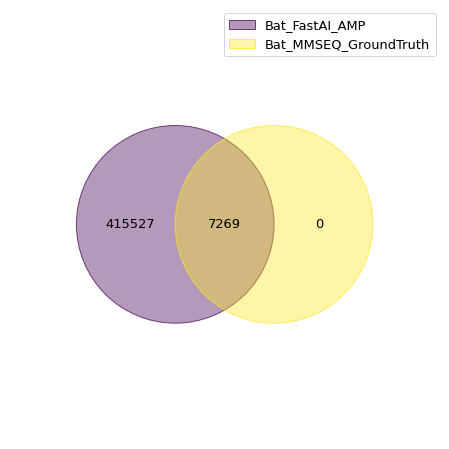

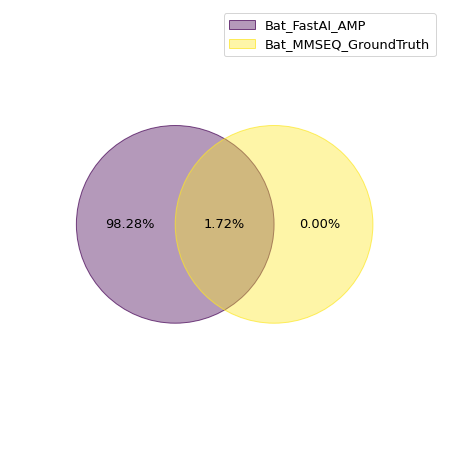

In [49]:
# AMP and Non AMP compare with ground truth
plot_ven_AMP_NonAMP("Bat_FastAI_AMP","Bat_MMSEQ_GroundTruth",
                    Bat_ML,
                    Bat_len10_truth
                   )

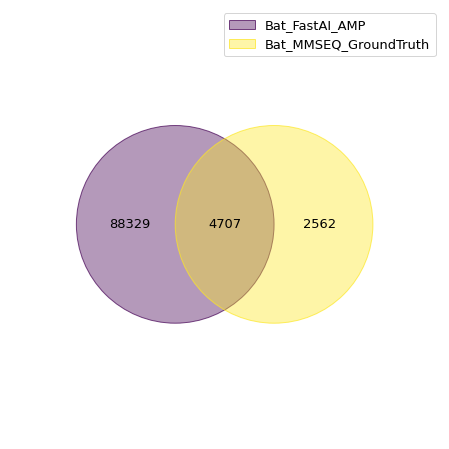

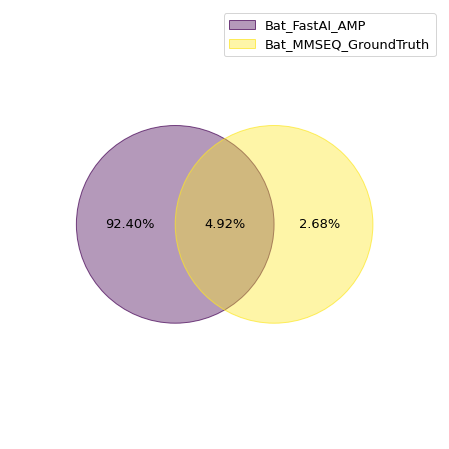

In [50]:
# AMP only compares with ground truth
plot_ven_AMP_NonAMP("Bat_FastAI_AMP","Bat_MMSEQ_GroundTruth",
                    Bat_AMPs_ML,
                    Bat_len10_truth
                   )

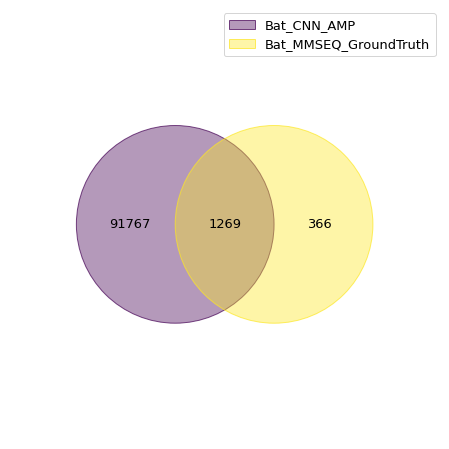

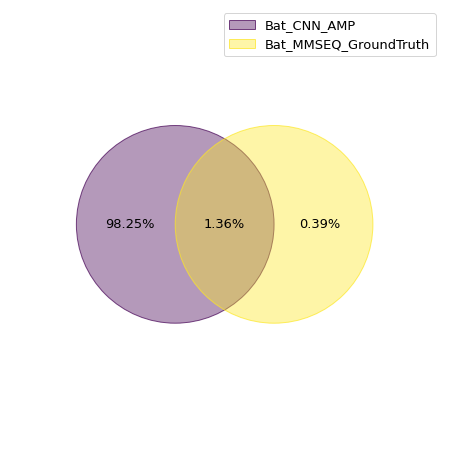

In [51]:
# AMP only compares with filtering 100% seq identity on ground truth
filtered_BAT_len10_truth =Bat_len10_truth[Bat_len10_truth['sequence_identity'] == 1]
filtered_BAT_total_AMPS_with100 = len(filtered_BAT_len10_truth['ID_Query'].unique())

plot_ven_AMP_NonAMP("Bat_CNN_AMP","Bat_MMSEQ_GroundTruth",
                    Bat_AMPs_ML,
                    filtered_BAT_len10_truth
                   )

In [58]:
# total 
accuracy = (4707/Bat_total_AMPS )*100
accuracy_100 = (1269/filtered_BAT_total_AMPS_with100 )*100
print("acurracy: %.2f" % accuracy)
print("acurracy Filtered 100 : %.2f" % accuracy_100)

acurracy: 64.75
acurracy Filtered 100 : 77.61


## with length <= 200

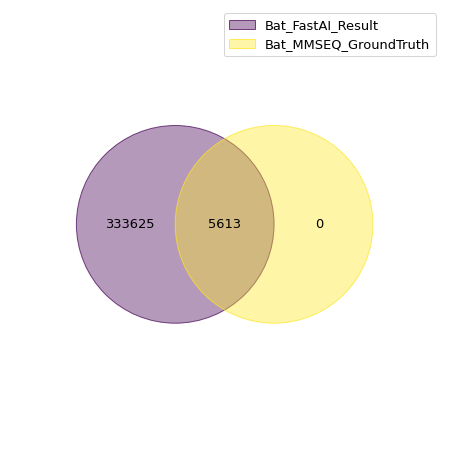

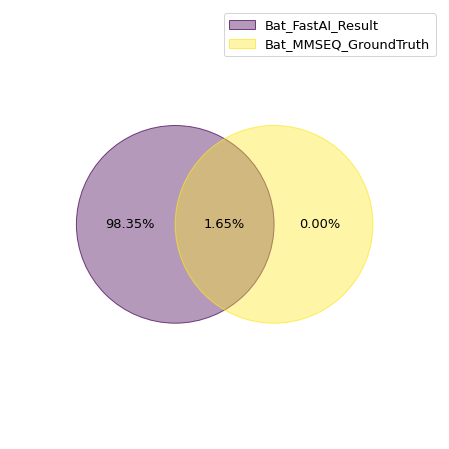

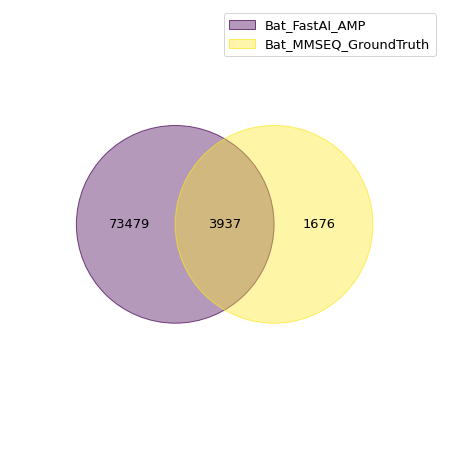

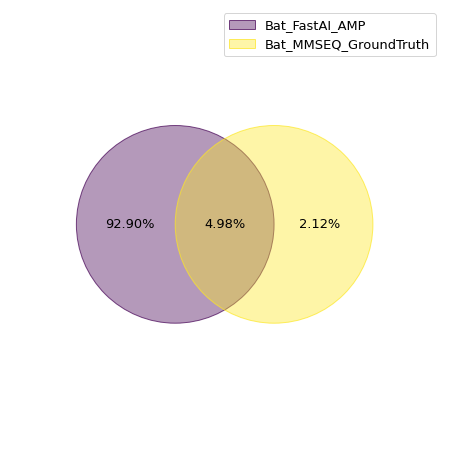

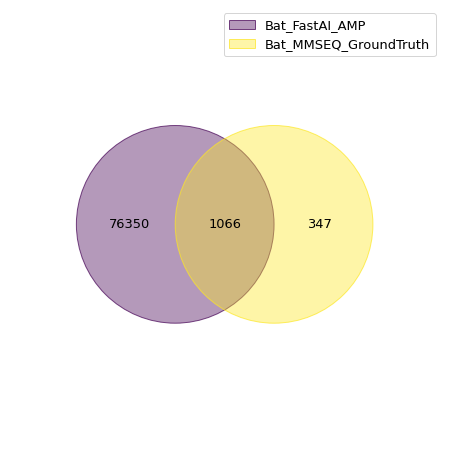

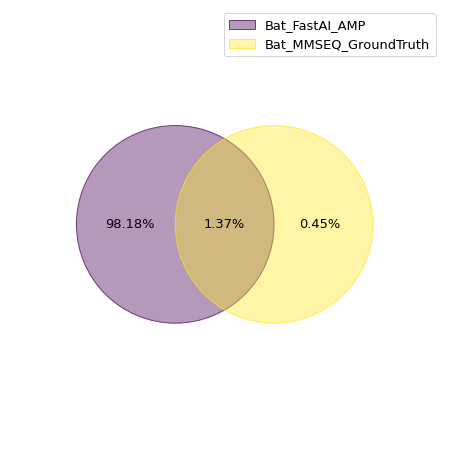

In [81]:
## with length <= 200

Bat_ML =  pd.read_pickle("/mnt/vdb/Bat/cd100/result_2_FastAI/Bat.len10.MLResult.plk")
Bat_ML = Bat_ML[Bat_ML["length"]<= 200]

Bat_len10_truth = pd.read_csv("/home/ubuntu/data/MMseqs.clus/output200/bat.len200.tsv"
                                      ,encoding = "ISO-8859-1", sep='\t',header=0)
Bat_total_AMPS = len(Bat_len10_truth['ID_Query'].unique())
Bat_AMPs_ML = Bat_ML[Bat_ML["class"] == 0]

# AMP and Non AMP compare with ground truth
plot_ven_AMP_NonAMP("Bat_FastAI_Result","Bat_MMSEQ_GroundTruth",
                    Bat_ML,
                    Bat_len10_truth
                   )
# AMP only compares with ground truth
plot_ven_AMP_NonAMP("Bat_FastAI_AMP","Bat_MMSEQ_GroundTruth",
                    Bat_AMPs_ML,
                    Bat_len10_truth
                   )
filtered_BAT_len10_truth =Bat_len10_truth[Bat_len10_truth['sequence_identity'] == 1]
filtered_BAT_total_AMPS_with100 = len(filtered_BAT_len10_truth['ID_Query'].unique())

plot_ven_AMP_NonAMP("Bat_FastAI_AMP","Bat_MMSEQ_GroundTruth",
                    Bat_AMPs_ML,
                    filtered_BAT_len10_truth
                   )

In [82]:

# total 
accuracy = (3937/Bat_total_AMPS )*100
accuracy_100 = (1066/filtered_BAT_total_AMPS_with100 )*100
print("acurracy: %.2f" % accuracy)
print("acurracy Filtered : %.2f" % accuracy_100)

acurracy: 70.14
acurracy Filtered : 75.44



## with length <= 30 (No ouput from MMseq)

In [ ]:

## with length <= 30


Bat_ML =  pd.read_pickle("/mnt/vdb/Bat/cd100/result_2_FastAI/Bat.len10.MLResult.plk")
Bat_ML = Bat_ML[Bat_ML["length"]<= 30]

Bat_len10_truth = pd.read_csv("/home/ubuntu/data/MMseqs.clus/output200/bat.len200.tsv"
                                      ,encoding = "ISO-8859-1", sep='\t',header=0)
Bat_total_AMPS = len(Bat_len10_truth['ID_Query'].unique())
Bat_AMPs_ML = Bat_ML[Bat_ML["class"] == 0]

# AMP and Non AMP compare with ground truth
plot_ven_AMP_NonAMP("Bat_FastAI_AMP","Bat_MMSEQ_GroundTruth",
                    Bat_ML,
                    Bat_len10_truth
                   )
# AMP only compares with ground truth
plot_ven_AMP_NonAMP("Bat_FastAI_AMP","Bat_MMSEQ_GroundTruth",
                    Bat_AMPs_ML,
                    Bat_len10_truth
                   )
filtered_BAT_len10_truth =Bat_len10_truth[Bat_len10_truth['sequence_identity'] == 1]
filtered_BAT_total_AMPS_with100 = len(filtered_BAT_len10_truth['ID_Query'].unique())

plot_ven_AMP_NonAMP("Bat_CNN_AMP","Bat_MMSEQ_GroundTruth",
                    Bat_AMPs_ML,
                    filtered_BAT_len10_truth
                   )



In [ ]:
# total 
accuracy_cal(267, DECockroach_truth_total_30 )
# 100% similarity 
accuracy_cal(41, DECockroach_total_30_with100 )

# Version 2 , CNN RMSpop

In [85]:
Bat_ML =  pd.read_pickle("/mnt/vdb/Bat/cd100/result_2_CNN/Bat.len10.MLResult.plk")
Bat_len10_truth = pd.read_csv("/home/ubuntu/data/MMseqs.clus/output/BAT.alnRes.m8.len10.tsv"
                                      ,encoding = "ISO-8859-1", sep='\t',header=0)
Bat_total_AMPS = len(Bat_len10_truth['ID_Query'].unique())
Bat_AMPs_ML = Bat_ML[Bat_ML["class"] == 0]

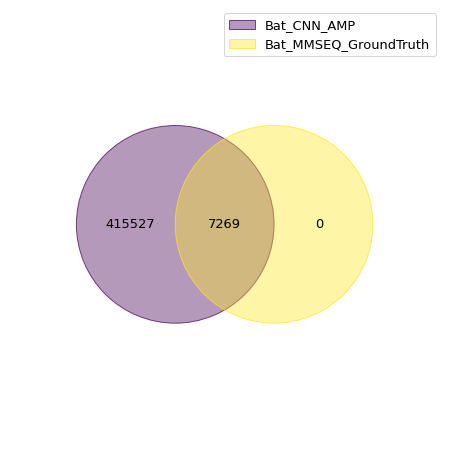

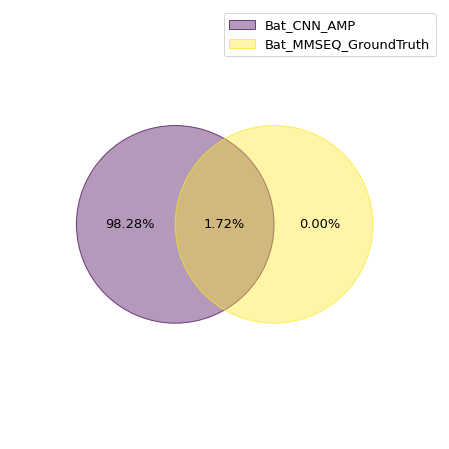

In [86]:
# AMP and Non AMP compare with ground truth
plot_ven_AMP_NonAMP("Bat_CNN_AMP","Bat_MMSEQ_GroundTruth",
                    Bat_ML,
                    Bat_len10_truth
                   )

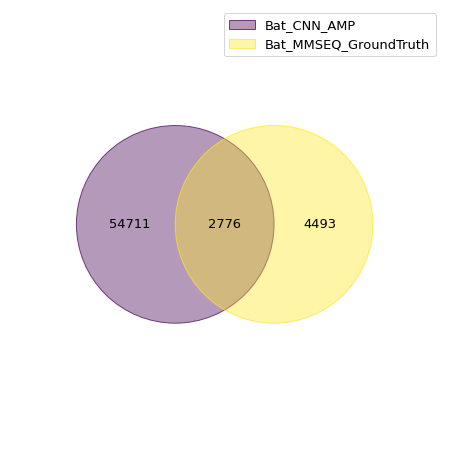

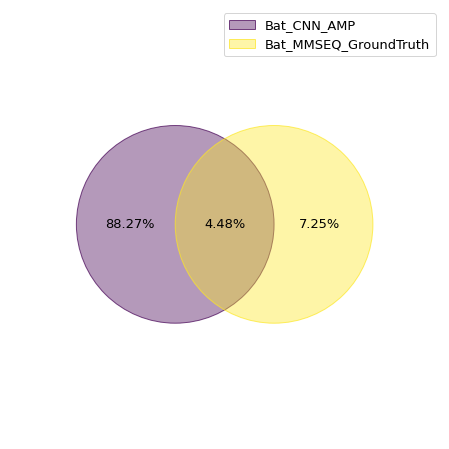

In [88]:


plot_ven_AMP_NonAMP("Bat_CNN_AMP","Bat_MMSEQ_GroundTruth",
                    Bat_AMPs_ML,
                    Bat_len10_truth
                   )

For sequence identiy s equal to 100%

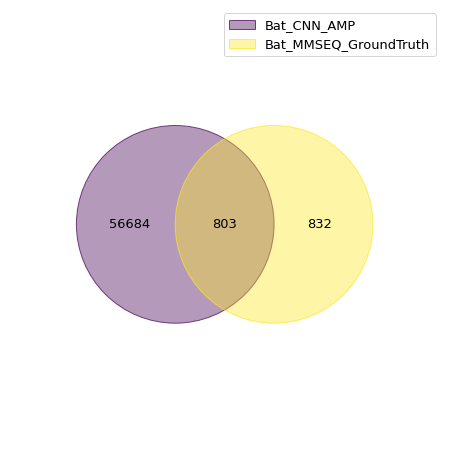

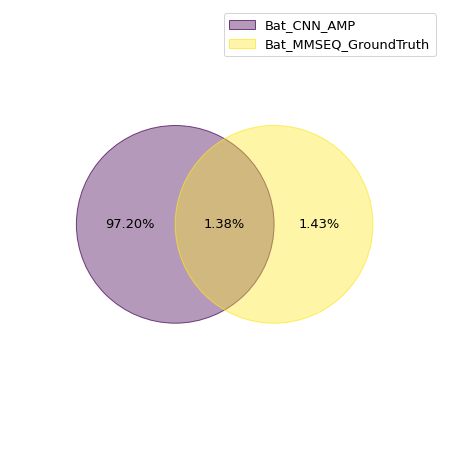

In [89]:
### 100% identity
filtered_BAT_len10_truth =Bat_len10_truth[Bat_len10_truth['sequence_identity'] == 1]
filtered_BAT_total_AMPS_with100 = len(filtered_BAT_len10_truth['ID_Query'].unique())

plot_ven_AMP_NonAMP("Bat_CNN_AMP","Bat_MMSEQ_GroundTruth",
                    Bat_AMPs_ML,
                    filtered_BAT_len10_truth
                   )

In [90]:
accuracy = (2766/Bat_total_AMPS )*100
accuracy_100 = (803/filtered_BAT_total_AMPS_with100 )*100
print("Baseline: %.2f" % accuracy)
print("Filtered: %.2f" % accuracy_100)

Baseline: 38.05
Filtered: 49.11


## with length <= 200

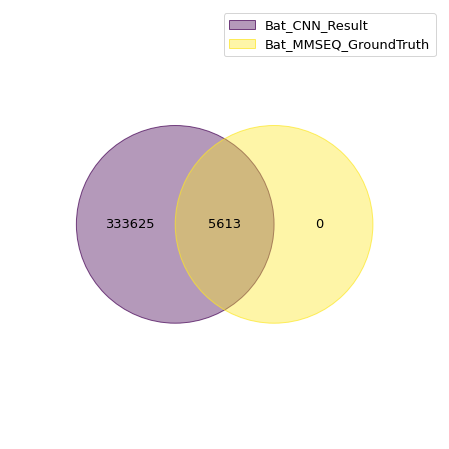

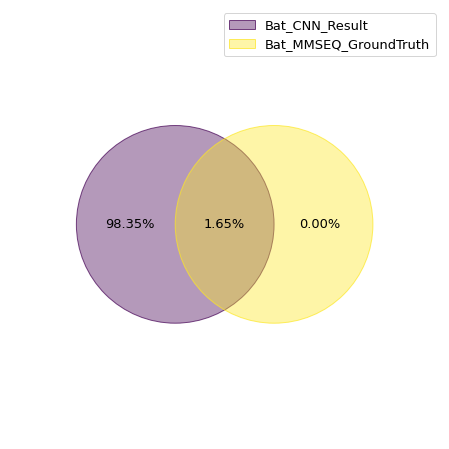

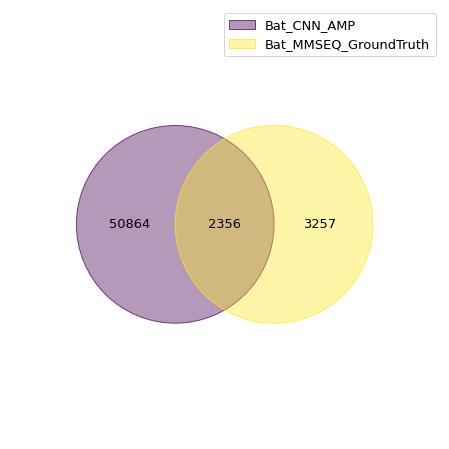

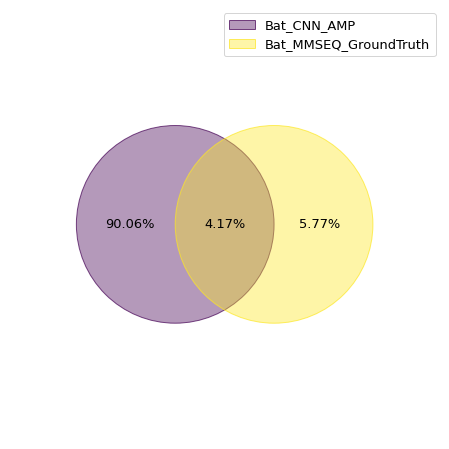

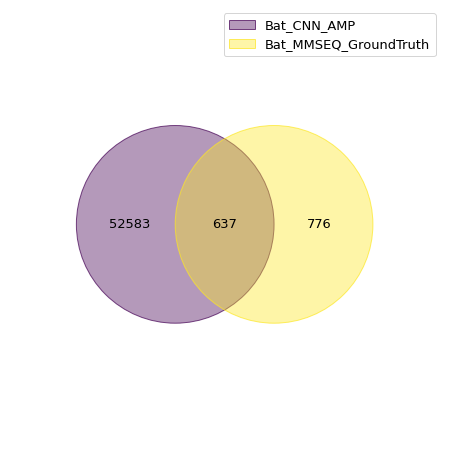

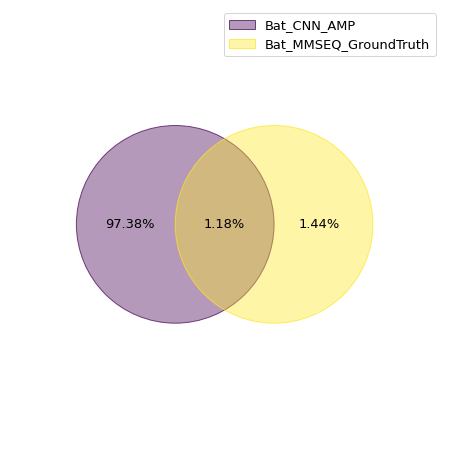

In [8]:

Bat_ML =  pd.read_pickle("/mnt/vdb/Bat/cd100/result_2_CNN_RMSpop/Bat.len10.MLResult.plk")
Bat_ML = Bat_ML[Bat_ML["length"]<= 200]

Bat_len10_truth = pd.read_csv("/home/ubuntu/data/MMseqs.clus/output200/bat.len200.tsv"
                                      ,encoding = "ISO-8859-1", sep='\t',header=0)
Bat_total_AMPS = len(Bat_len10_truth['ID_Query'].unique())
Bat_AMPs_ML = Bat_ML[Bat_ML["class"] == 0]

# AMP and Non AMP compare with ground truth
plot_ven_AMP_NonAMP("Bat_CNN_Result","Bat_MMSEQ_GroundTruth",
                    Bat_ML,
                    Bat_len10_truth
                   )
# AMP only compares with ground truth
plot_ven_AMP_NonAMP("Bat_CNN_AMP","Bat_MMSEQ_GroundTruth",
                    Bat_AMPs_ML,
                    Bat_len10_truth
                   )
filtered_BAT_len10_truth =Bat_len10_truth[Bat_len10_truth['sequence_identity'] == 1]
filtered_BAT_total_AMPS_with100 = len(filtered_BAT_len10_truth['ID_Query'].unique())

plot_ven_AMP_NonAMP("Bat_CNN_AMP","Bat_MMSEQ_GroundTruth",
                    Bat_AMPs_ML,
                    filtered_BAT_len10_truth
                   )

In [92]:

# total 
accuracy = (2536/Bat_total_AMPS )*100
accuracy_100 = (637/filtered_BAT_total_AMPS_with100 )*100
print("acurracy: %.2f" % accuracy)
print("acurracy Filtered : %.2f" % accuracy_100)

acurracy: 45.18
acurracy Filtered : 45.08


## with length <= 30 (No ouput from MMseq)

# Ensemble 

In [17]:
Bat_ML =  pd.read_pickle("/mnt/vdb/Bat/cd100/result_2_Ensemble/Bat.len10.MLResult.plk")
Bat_len10_truth = pd.read_csv("/home/ubuntu/data/MMseqs.clus/output/BAT.alnRes.m8.len10.tsv"
                                      ,encoding = "ISO-8859-1", sep='\t',header=0)
Bat_total_AMPS = len(Bat_len10_truth['ID_Query'].unique())
Bat_AMPs_ML = Bat_ML[Bat_ML["class"] == 0]

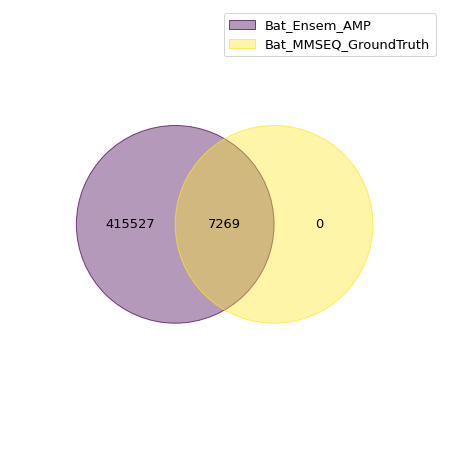

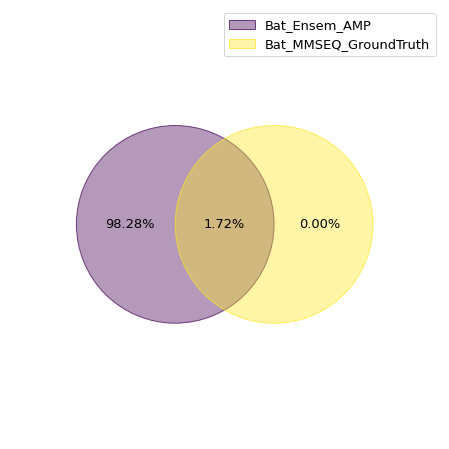

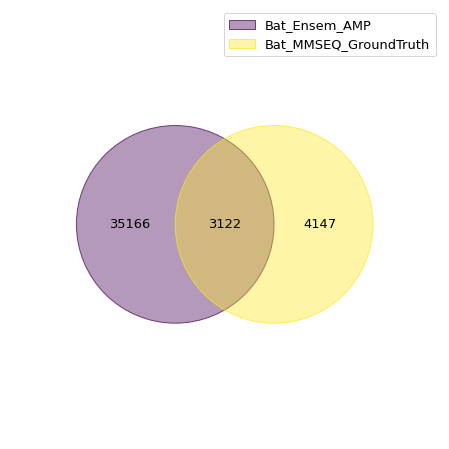

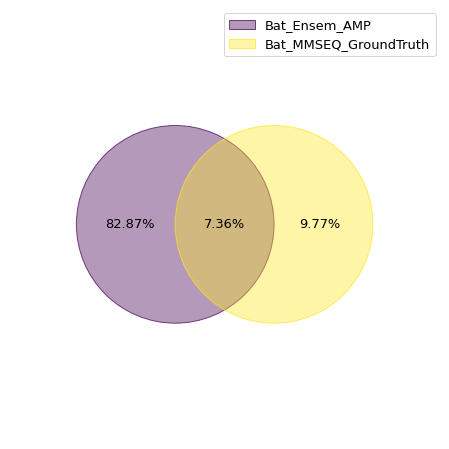

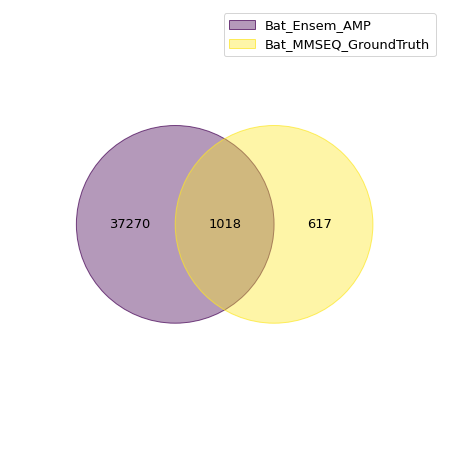

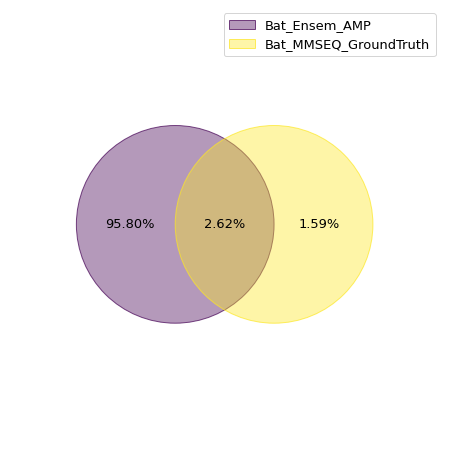

In [18]:
###### AMP and Non AMP compare with ground truth
plot_ven_AMP_NonAMP("Bat_Ensem_AMP","Bat_MMSEQ_GroundTruth",
                    Bat_ML,
                    Bat_len10_truth
                   )

plot_ven_AMP_NonAMP("Bat_Ensem_AMP","Bat_MMSEQ_GroundTruth",
                    Bat_AMPs_ML,
                    Bat_len10_truth
                   )

### 100% identity
filtered_BAT_len10_truth =Bat_len10_truth[Bat_len10_truth['sequence_identity'] == 1]
filtered_BAT_total_AMPS_with100 = len(filtered_BAT_len10_truth['ID_Query'].unique())

plot_ven_AMP_NonAMP("Bat_Ensem_AMP","Bat_MMSEQ_GroundTruth",
                    Bat_AMPs_ML,
                    filtered_BAT_len10_truth
                   )

In [6]:
accuracy = (3146/Bat_total_AMPS )*100
accuracy_100 = (1018/filtered_BAT_total_AMPS_with100 )*100
print("Baseline: %.2f" % accuracy)
print("Filtered: %.2f" % accuracy_100)

Baseline: 43.28
Filtered: 62.26


## with length <= 200

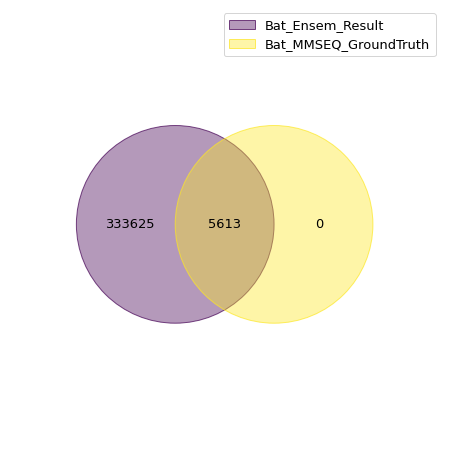

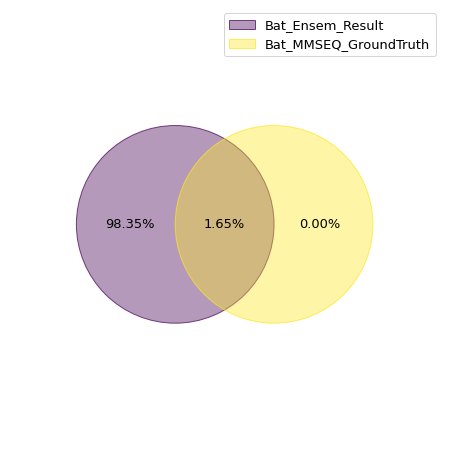

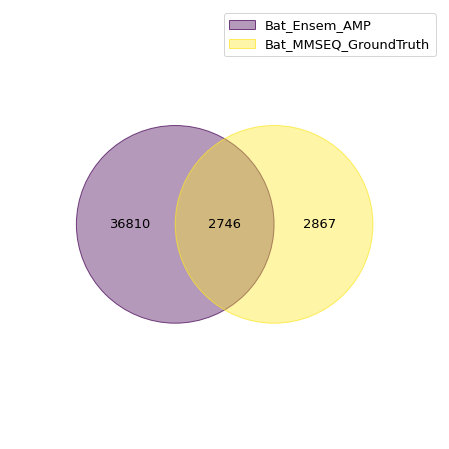

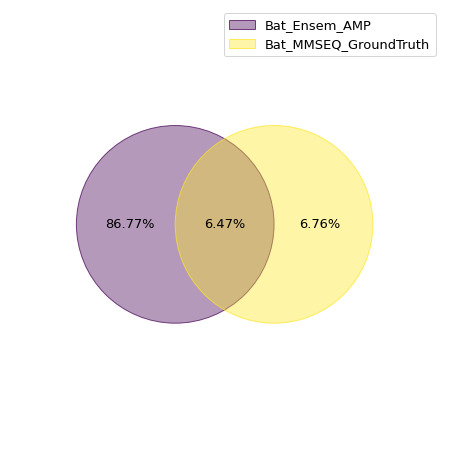

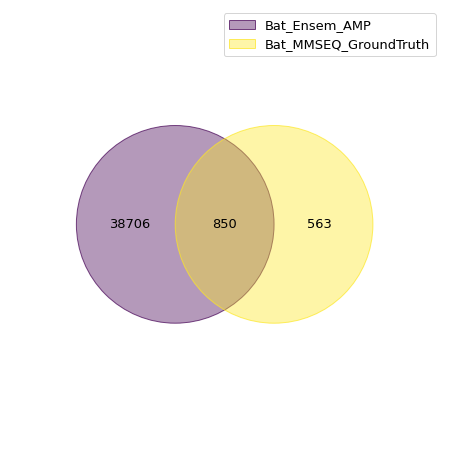

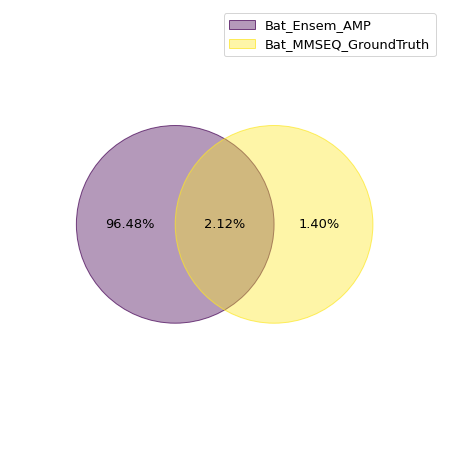

In [9]:

Bat_ML =  pd.read_pickle("/mnt/vdb/Bat/cd100/result_2_Ensemble/Bat.len10.MLResult.plk")
Bat_ML = Bat_ML[Bat_ML["length"]<= 200]

Bat_len10_truth = pd.read_csv("/home/ubuntu/data/MMseqs.clus/output200/bat.len200.tsv"
                                      ,encoding = "ISO-8859-1", sep='\t',header=0)
Bat_total_AMPS = len(Bat_len10_truth['ID_Query'].unique())
Bat_AMPs_ML = Bat_ML[Bat_ML["class"] == 0]

# AMP and Non AMP compare with ground truth
plot_ven_AMP_NonAMP("Bat_Ensem_Result","Bat_MMSEQ_GroundTruth",
                    Bat_ML,
                    Bat_len10_truth
                   )
# AMP only compares with ground truth
plot_ven_AMP_NonAMP("Bat_Ensem_AMP","Bat_MMSEQ_GroundTruth",
                    Bat_AMPs_ML,
                    Bat_len10_truth
                   )
filtered_BAT_len10_truth =Bat_len10_truth[Bat_len10_truth['sequence_identity'] == 1]
filtered_BAT_total_AMPS_with100 = len(filtered_BAT_len10_truth['ID_Query'].unique())

plot_ven_AMP_NonAMP("Bat_Ensem_AMP","Bat_MMSEQ_GroundTruth",
                    Bat_AMPs_ML,
                    filtered_BAT_len10_truth
                   )

In [11]:
# total 
accuracy = (2746/Bat_total_AMPS )*100
accuracy_100 = (850/filtered_BAT_total_AMPS_with100 )*100
print("acurracy: %.2f" % accuracy)
print("acurracy Filtered : %.2f" % accuracy_100)

acurracy: 48.92
acurracy Filtered : 60.16


# SVM

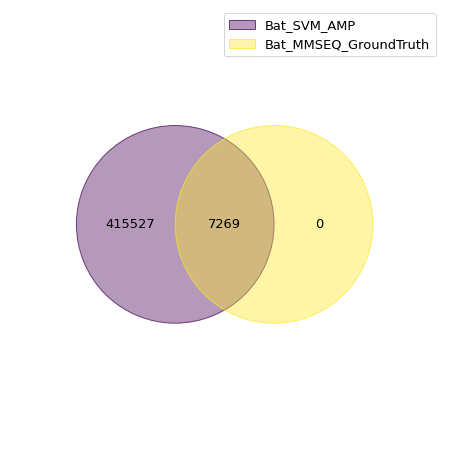

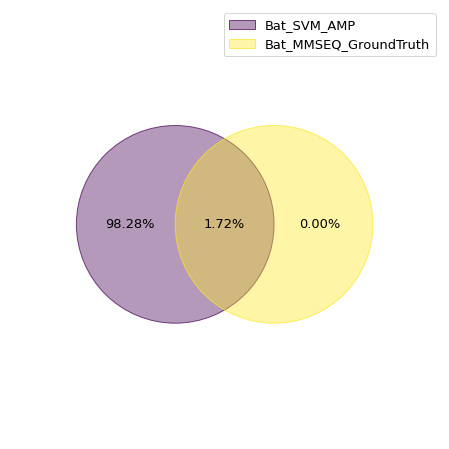

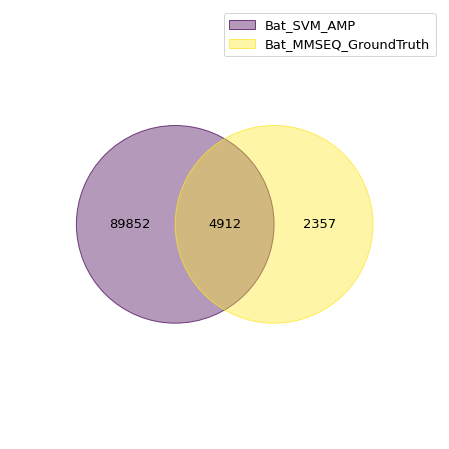

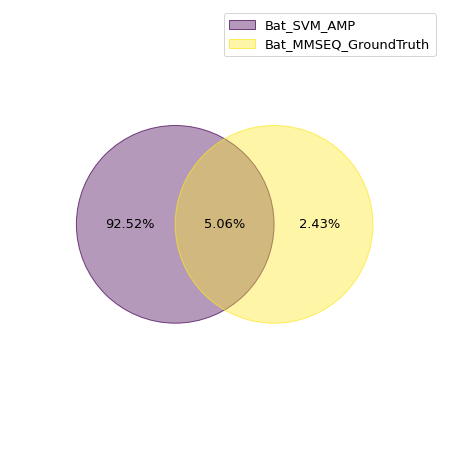

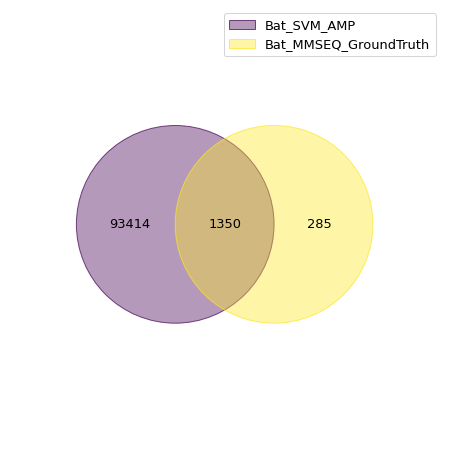

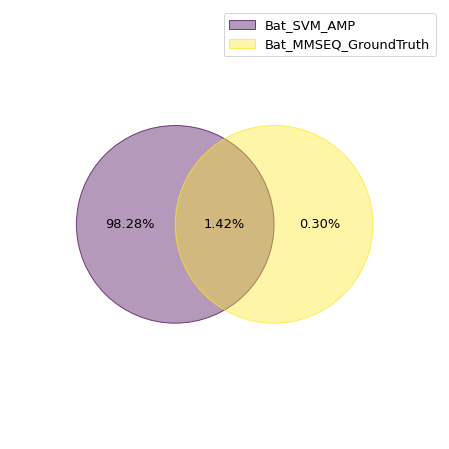

In [12]:
method = "SVM"
Bat_ML =  pd.read_pickle("/mnt/vdb/Bat/cd100/result_2_"+ method +"/Bat.len10.MLResult.plk")
Bat_len10_truth = pd.read_csv("/home/ubuntu/data/MMseqs.clus/output/BAT.alnRes.m8.len10.tsv"
                                      ,encoding = "ISO-8859-1", sep='\t',header=0)
Bat_total_AMPS = len(Bat_len10_truth['ID_Query'].unique())
Bat_AMPs_ML = Bat_ML[Bat_ML["class"] == 0]

# AMP and Non AMP compare with ground truth
plot_ven_AMP_NonAMP("Bat_"+ method +"_AMP","Bat_MMSEQ_GroundTruth",
                    Bat_ML,
                    Bat_len10_truth
                   )

plot_ven_AMP_NonAMP("Bat_"+ method +"_AMP","Bat_MMSEQ_GroundTruth",
                    Bat_AMPs_ML,
                    Bat_len10_truth
                   )

### 100% identity
filtered_BAT_len10_truth =Bat_len10_truth[Bat_len10_truth['sequence_identity'] == 1]
filtered_BAT_total_AMPS_with100 = len(filtered_BAT_len10_truth['ID_Query'].unique())

plot_ven_AMP_NonAMP("Bat_"+ method +"_AMP","Bat_MMSEQ_GroundTruth",
                    Bat_AMPs_ML,
                    filtered_BAT_len10_truth
                   )

In [14]:
# total 
accuracy_cal(4912, Bat_total_AMPS )
# 100% similarity 
accuracy_cal(1350, filtered_BAT_total_AMPS_with100 )

 Accuracy Percentage = 67.57
 Accuracy Percentage = 82.57


## <= 200

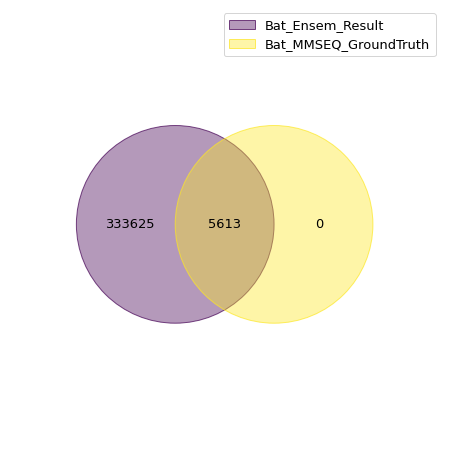

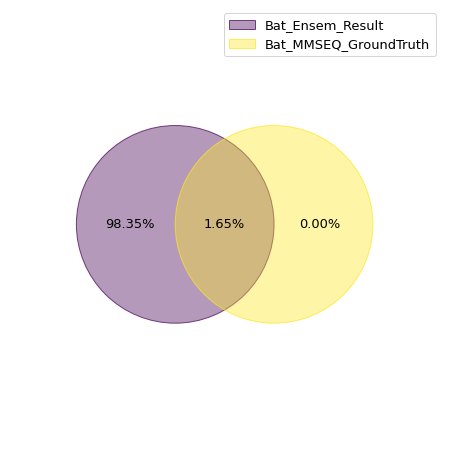

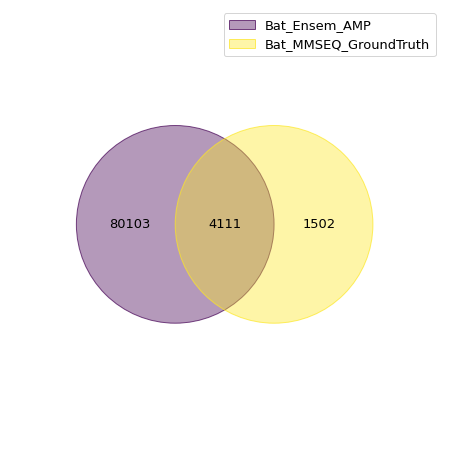

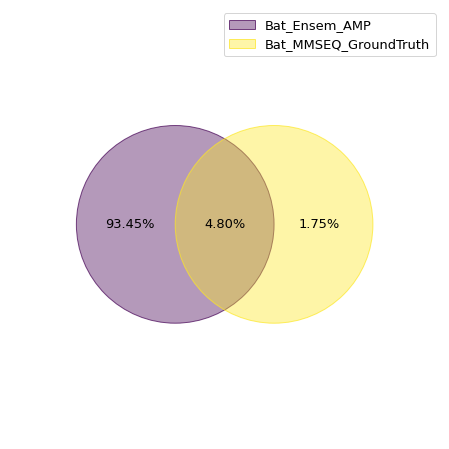

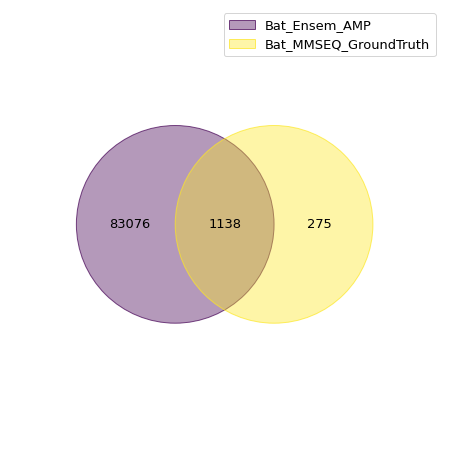

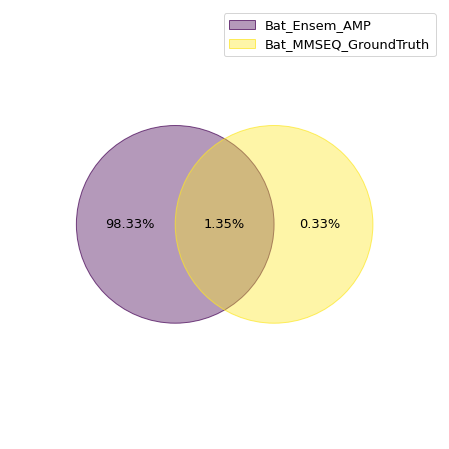

In [15]:

Bat_ML =  pd.read_pickle("/mnt/vdb/Bat/cd100/result_2_SVM/Bat.len10.MLResult.plk")
Bat_ML = Bat_ML[Bat_ML["length"]<= 200]

Bat_len10_truth = pd.read_csv("/home/ubuntu/data/MMseqs.clus/output200/bat.len200.tsv"
                                      ,encoding = "ISO-8859-1", sep='\t',header=0)
Bat_total_AMPS = len(Bat_len10_truth['ID_Query'].unique())
Bat_AMPs_ML = Bat_ML[Bat_ML["class"] == 0]

# AMP and Non AMP compare with ground truth
plot_ven_AMP_NonAMP("Bat_Ensem_Result","Bat_MMSEQ_GroundTruth",
                    Bat_ML,
                    Bat_len10_truth
                   )
# AMP only compares with ground truth
plot_ven_AMP_NonAMP("Bat_Ensem_AMP","Bat_MMSEQ_GroundTruth",
                    Bat_AMPs_ML,
                    Bat_len10_truth
                   )
filtered_BAT_len10_truth =Bat_len10_truth[Bat_len10_truth['sequence_identity'] == 1]
filtered_BAT_total_AMPS_with100 = len(filtered_BAT_len10_truth['ID_Query'].unique())

plot_ven_AMP_NonAMP("Bat_Ensem_AMP","Bat_MMSEQ_GroundTruth",
                    Bat_AMPs_ML,
                    filtered_BAT_len10_truth
                   )

In [16]:
# total 
accuracy = (4111/Bat_total_AMPS )*100
accuracy_100 = (1138/filtered_BAT_total_AMPS_with100 )*100
print("acurracy: %.2f" % accuracy)
print("acurracy Filtered : %.2f" % accuracy_100)

acurracy: 73.24
acurracy Filtered : 80.54
